<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/AD_Ad0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Instructions for Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Required Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import itertools

# Setting Random Seeds for Reproducibility in NumPy and TensorFlow

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

> used to make sure that the randomness in NumPy and TensorFlow is consistent across different runs of the program, enabling reproducibility.

In [4]:
# Update the data directory to point to your Google Drive
data_dir = '/content/drive/MyDrive/ADNI'

# Loading Image Data from Directory

In [5]:
# Load data
def load_data(data_dir):
    images, labels = [], []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(64, 64))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Loading and One-Hot Encoding Labels for Image Data

In [6]:
images, labels = load_data(data_dir)
labels = np.where(labels == 'AD', 1, 0)
one_hot = np.zeros((labels.shape[0], 2))
one_hot[np.arange(labels.shape[0]), labels] = 1
labels = one_hot

In [ ]:
print(labels)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


# Splitting Data into Training, Validation, and Test Sets

In [9]:
# Train-validation-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.05, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [10]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1422, 64, 64, 3) (1422, 2)
(158, 64, 64, 3) (158, 2)
(84, 64, 64, 3) (84, 2)


# Visualizing Class Distribution Prior to Augmentation

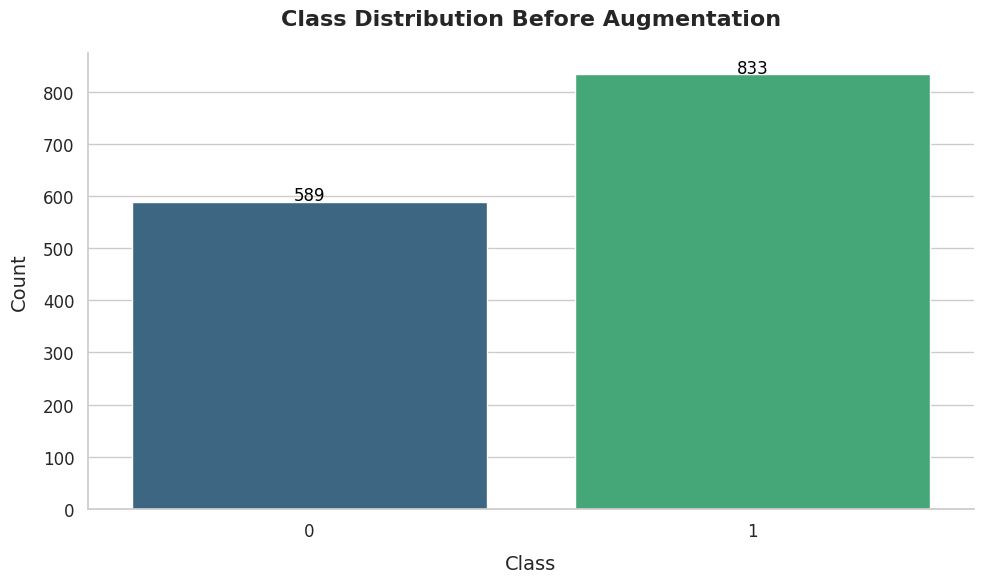

In [ ]:
# Set the style for the plot
sns.set(style="whitegrid", palette="pastel")

# Create the countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=np.argmax(y_train, 1), hue=np.argmax(y_train, 1), palette="viridis", legend=False)

# Add title and labels
plt.title('Class Distribution Before Augmentation', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Class', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)

# Customize the tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Add data labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5),
                textcoords='offset points')

# Remove the top and right spines
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

# Configure Batch Size for Model Training

In [11]:
batch_size = 64


# Applying Data Augmentation Techniques

In [12]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [13]:
train_datagen_test = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
train_generator_test = train_datagen_test.flow(X_train, y_train, batch_size=batch_size)

val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

# Display class distribution after augmentation
augmented_images, _ = next(train_generator)

# Class Distribution After Augmentation

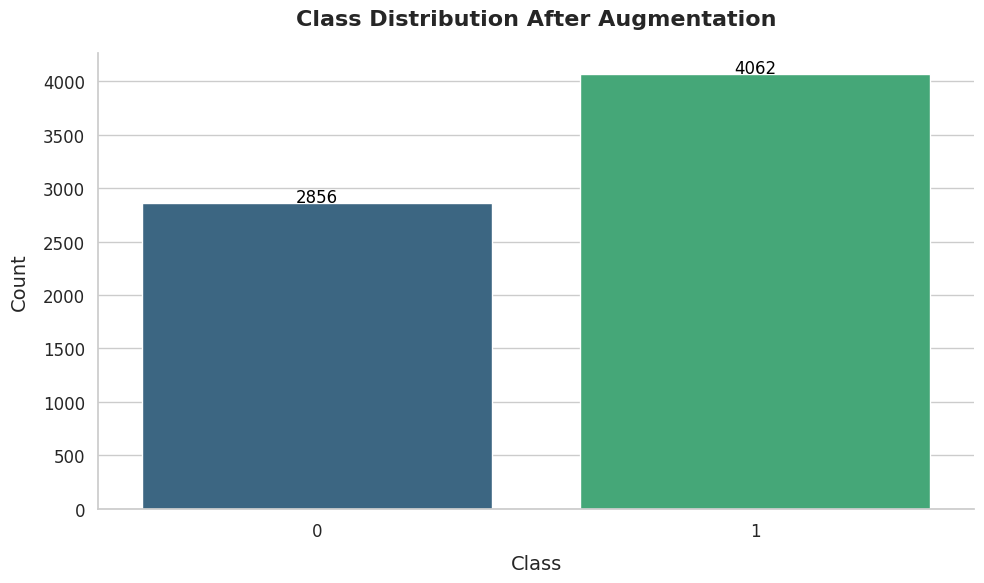

In [ ]:
# Generate augmented labels
augmented_labels = []
for _ in range((len(y_train) * 5 // batch_size) + 1):
    _, batch_labels = next(train_generator)
    augmented_labels.extend(batch_labels)

# Convert augmented_labels to a numpy array for easier manipulation
augmented_labels = np.array(augmented_labels)

# Set the style for the plot
sns.set(style="whitegrid", palette="pastel")

# Create the countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=np.argmax(augmented_labels, 1), hue=np.argmax(augmented_labels, 1), palette="viridis", legend=False)

# Add title and labels
plt.title('Class Distribution After Augmentation', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Class', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)

# Customize the tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Add data labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5),
                textcoords='offset points')

# Remove the top and right spines
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

# Display 5 Original Images with Labels and 10 Augmented Images

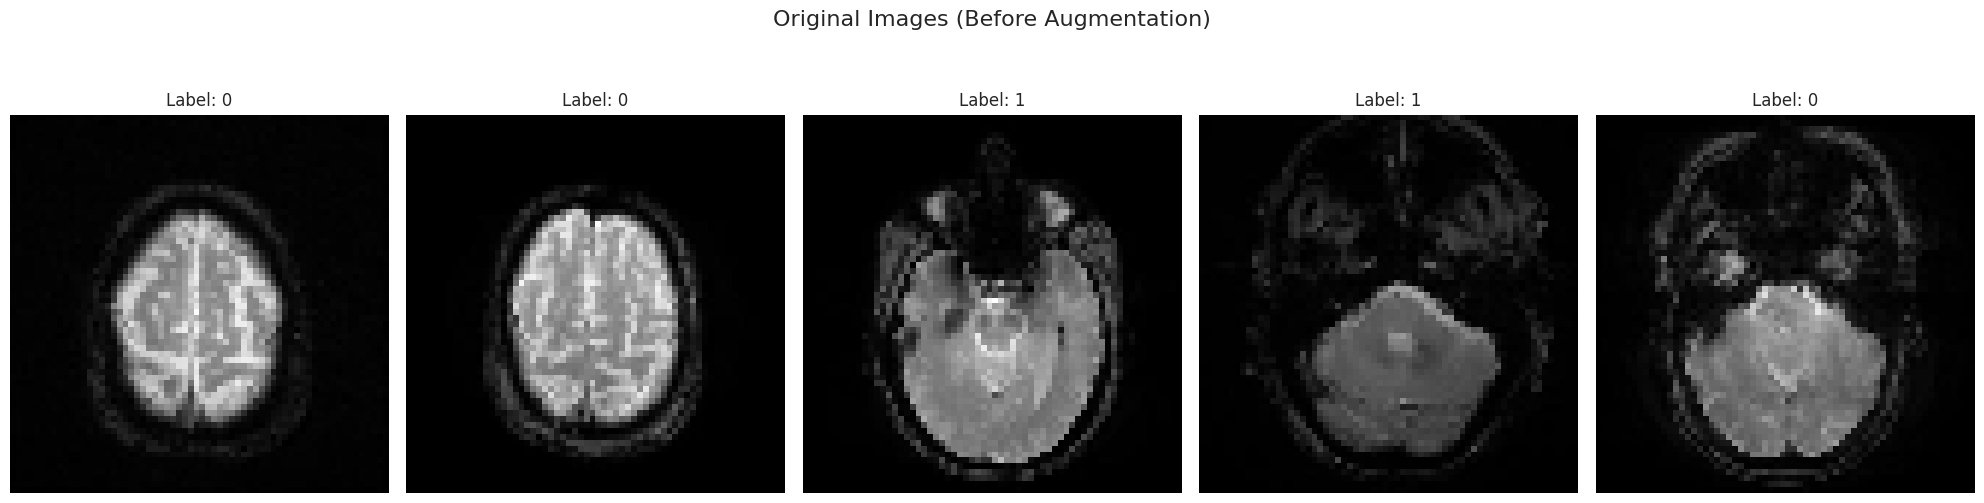

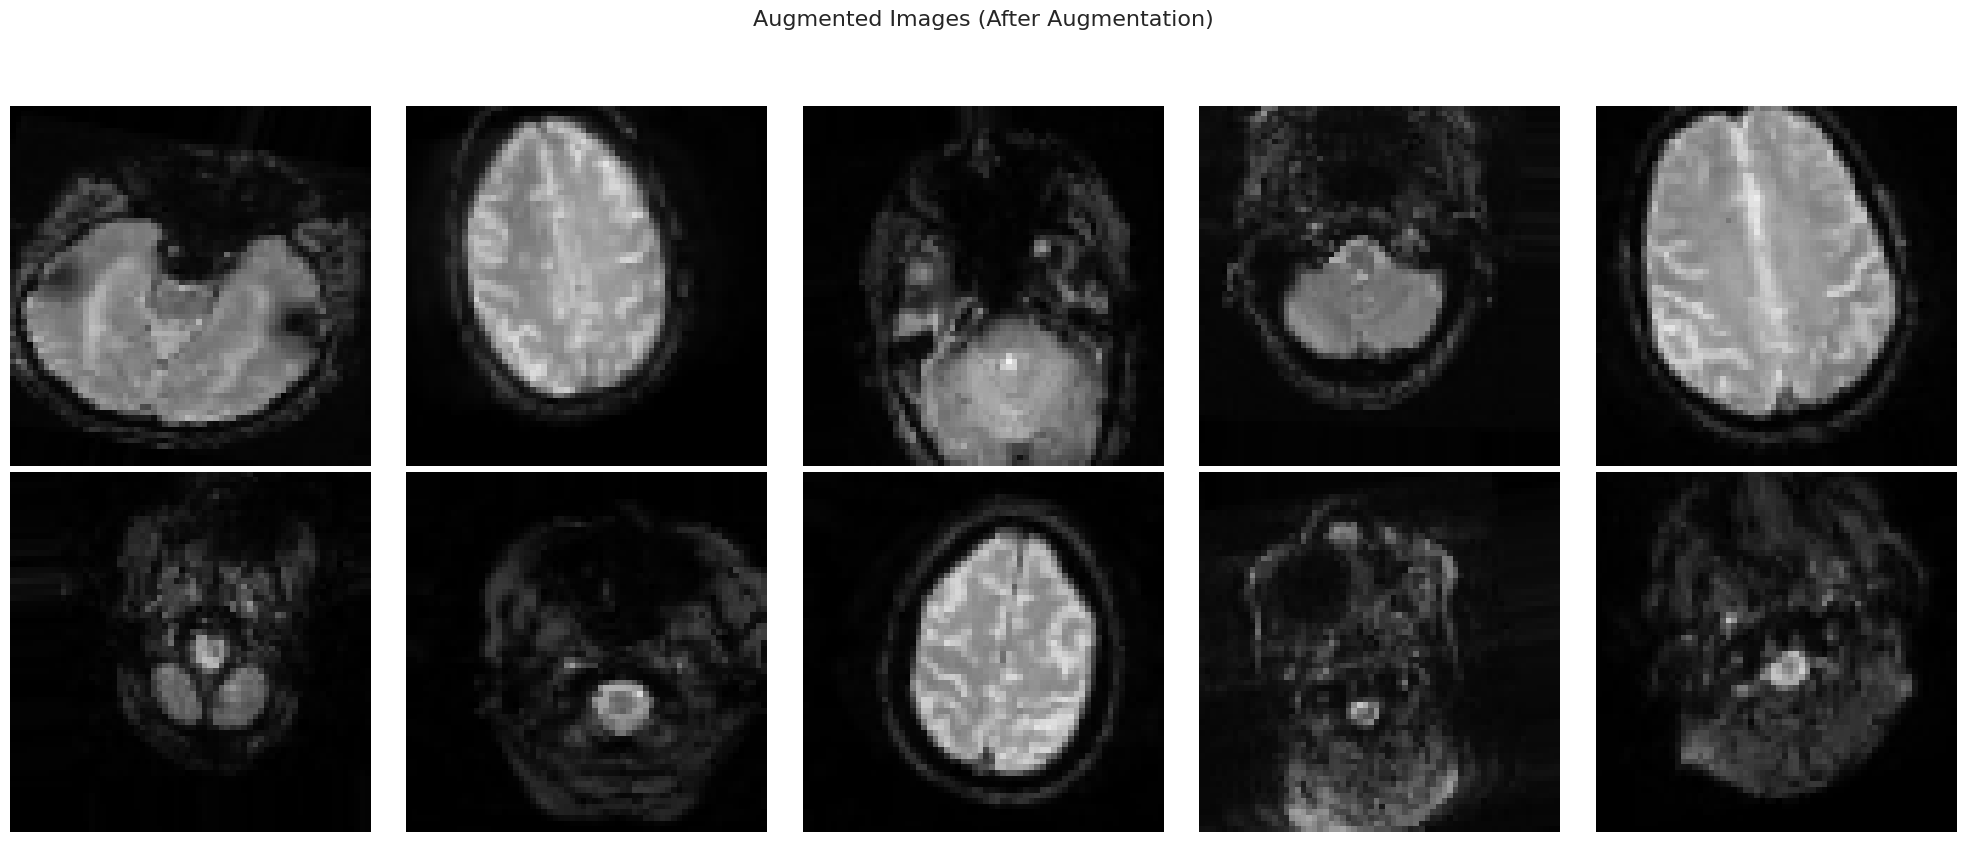

In [ ]:
# Display 5 original images with labels
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle('Original Images (Before Augmentation)', fontsize=16, y=1.05)

for i in range(5):
    random_index = np.random.randint(0, len(X_train))  # Randomly select an image from the training set
    ax = axes[i]
    ax.imshow(X_train[random_index].astype('uint8'))  # Display the original image
    ax.set_title(f'Label: {np.argmax(y_train[random_index])}')  # Show the corresponding label
    ax.axis('off')

plt.tight_layout()
plt.show()

# Display 10 augmented images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns for 10 images
fig.suptitle('Augmented Images (After Augmentation)', fontsize=16, y=1.05)

for i in range(10):
    random_index = np.random.randint(0, len(augmented_images))  # Randomly select an augmented image
    ax = axes[i // 5, i % 5]  # Arrange images in 2 rows and 5 columns
    ax.imshow(augmented_images[random_index])  # Display the augmented image
    ax.axis('off')

plt.tight_layout()
plt.show()

# Models Definitions


In [ ]:
# Define models
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 60, 60, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 26, 26, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 10816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │       1,384,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,458,530 (5.56 MB)

 Trainable params: 1,458,530 (5.56 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,410 (6.20 MB)

 Trainable params: 1,625,410 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model3.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 60, 60, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │       3,686,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,705,058 (14.13 MB)

 Trainable params: 3,705,058 (14.13 MB)

 Non-trainable params: 0 (0.00 B)

## Create a Dictionary Named models to Store Three Different Keras Models

In [ ]:
models = {
    "Model 1": model1,
    "Model 2": model2,
    "Model 3": model3
}

## Define the Checkpoint Configuration


In [ ]:
# Define the checkpoint directory in Google Drive
checkpoint_dir = '/content/drive/MyDrive/chksAD'

# Create the directory if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Define the checkpoint path
checkpoint_path = os.path.join(checkpoint_dir, 'best_model.keras')

# Set up the ModelCheckpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,  # Save only the best model
    monitor='val_loss',    # Monitor validation loss
    mode='min',            # Minimize validation loss
    verbose=1              # Print a message when saving the model
)


# Define Compile and Train Functions


In [ ]:
def compile_and_train(model, train_generator, val_generator, checkpoint_callback, epochs=100):
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_generator,
                        epochs=epochs,
                         validation_data=val_generator,
                        callbacks=[checkpoint_callback])
    return history

# Define Function to Plot Training History


In [ ]:
def plot_history(name, history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(name)
    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].plot(history.history['accuracy'], label='Train Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    plt.show()

# Evaluate and Plot Confusion Matrix

In [ ]:
def evaluate_and_plot_confusion_matrix(name, model, generator, y, class_names=None, save_plots=False):
    # Evaluate the model
    test_loss, test_acc = model.evaluate(generator)
    print(f"Test accuracy: {test_acc}", f"Test loss: {test_loss}")

    # Extract true labels
    Y_true = []
    generator.reset()
    for _ in range((len(y) // batch_size) + 1):
        _, batch_labels = next(generator)
        Y_true.extend(batch_labels)
    Y_true = np.argmax(Y_true, 1)

    # Generate predictions
    generator.reset()
    Y_pred = model.predict(generator)
    Y_pred_classes = np.argmax(Y_pred, 1)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(Y_true, Y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name + ' Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    if save_plots:
        plt.savefig(os.path.join(checkpoint_dir, f'{name}_ROC_Curve.png'))
    plt.show()

    # Plot confusion matrix
    conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(name + ' Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names)) if class_names else np.arange(2)
    plt.xticks(tick_marks, class_names if class_names else ['Class 0', 'Class 1'], rotation=45)
    plt.yticks(tick_marks, class_names if class_names else ['Class 0', 'Class 1'])
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if save_plots:
        plt.savefig(os.path.join(checkpoint_dir, f'{name}_Confusion_Matrix.png'))
    plt.show()

    # Compute and print metrics
    accuracy = accuracy_score(Y_true, Y_pred_classes)
    precision = precision_score(Y_true, Y_pred_classes)
    recall = recall_score(Y_true, Y_pred_classes)
    f1 = f1_score(Y_true, Y_pred_classes)
    print(f'Accuracy: {accuracy*100:.2f}')
    print(f'Precision: {precision*100:.2f}')
    print(f'Recall: {recall*100:.2f}')
    print(f'F1 Score: {f1:.3f}')
    print(f'AUC: {roc_auc:.3f}')
    print(f"Loss: {test_loss:.3f}")

# Training and Evaluation Pipeline


Training Model 1...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.5460 - loss: 0.6802
Epoch 1: val_loss improved from inf to 0.68233, saving model to /content/drive/MyDrive/chksAD/best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 416ms/step - accuracy: 0.5454 - loss: 0.6814 - val_accuracy: 0.5886 - val_loss: 0.6823
Epoch 2/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5794 - loss: 0.6768
Epoch 2: val_loss improved from 0.68233 to 0.64637, saving model to /content/drive/MyDrive/chksAD/best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5800 - loss: 0.6763 - val_accuracy: 0.5823 - val_loss: 0.6464
Epoch 3/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5603 - loss: 0.6749
Epoch 3: val_loss improved from 0.64637 to 0.64019, saving model to /content/drive/MyDrive/chksAD/best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.5630 - loss: 0.6738 - val_accuracy: 0.5886 - val_loss: 0.6402
Epoch 4/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy

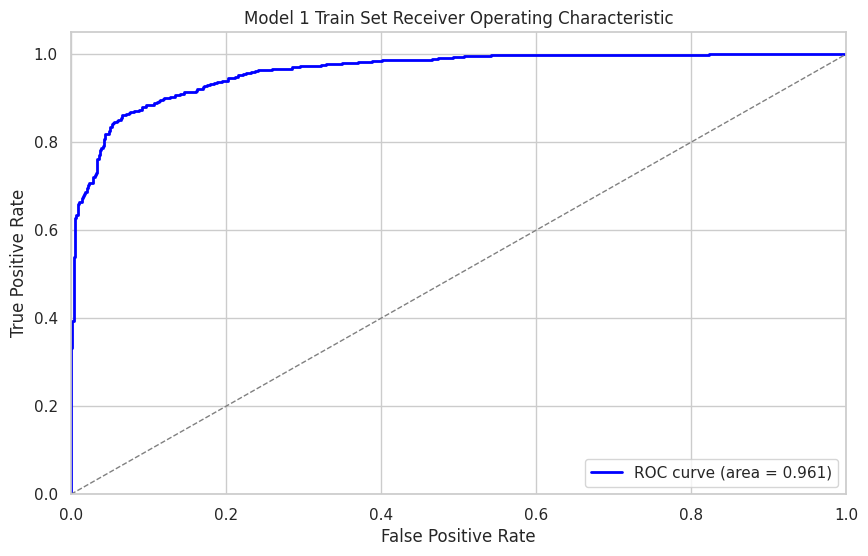

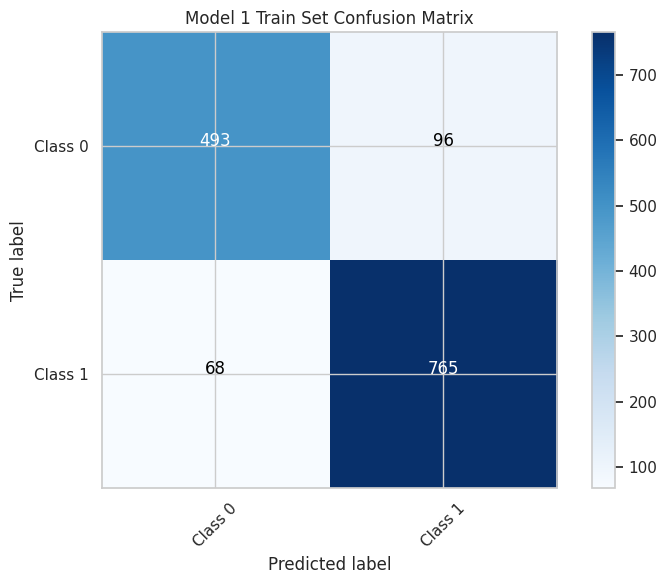

Accuracy: 88.47
Precision: 88.85
Recall: 91.84
F1 Score: 0.903
AUC: 0.961
Loss: 0.252
Evaluating Model 1 on Validation set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7791 - loss: 0.4054 
Test accuracy: 0.7848101258277893 Test loss: 0.40481850504875183
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


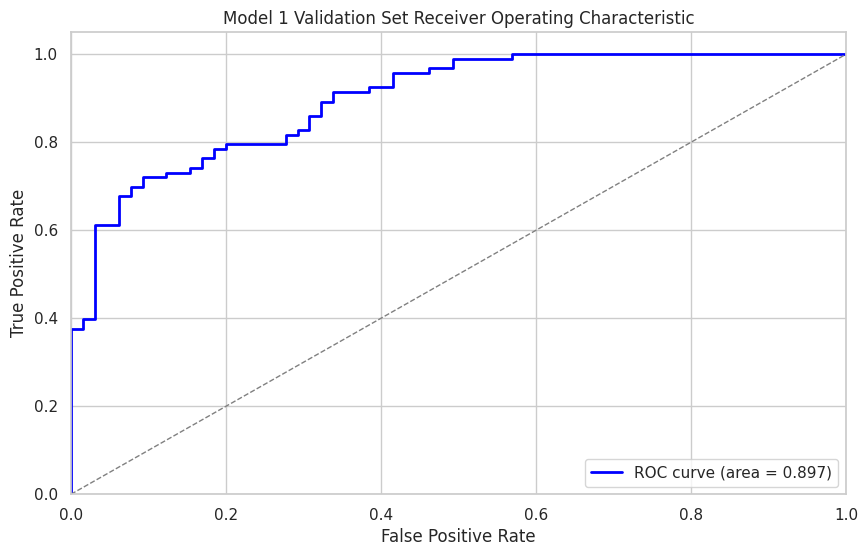

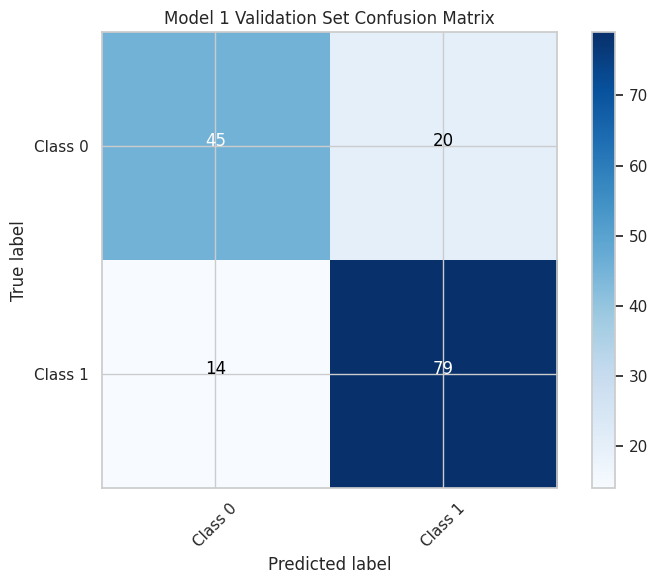

Accuracy: 78.48
Precision: 79.80
Recall: 84.95
F1 Score: 0.823
AUC: 0.897
Loss: 0.405
Evaluating Model 1 on Test set...
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8438 - loss: 0.4159

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8289 - loss: 0.4145
Test accuracy: 0.8214285969734192 Test loss: 0.4137169122695923
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


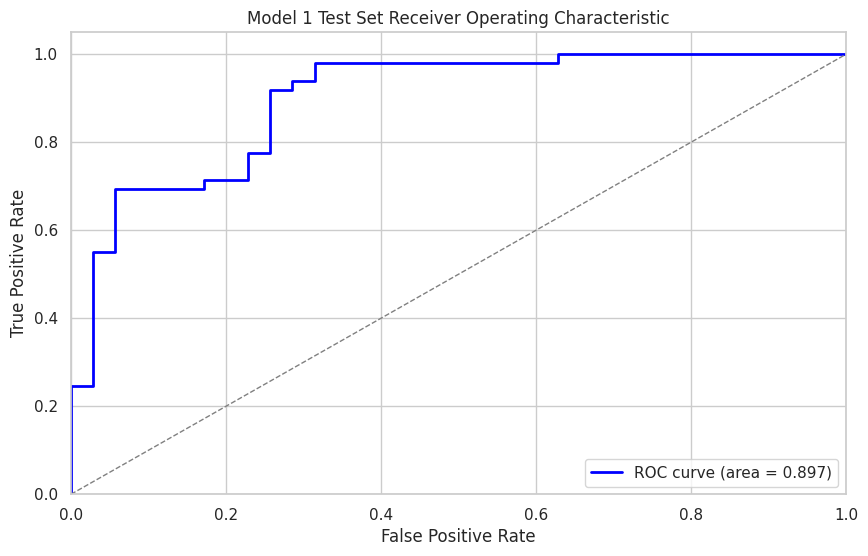

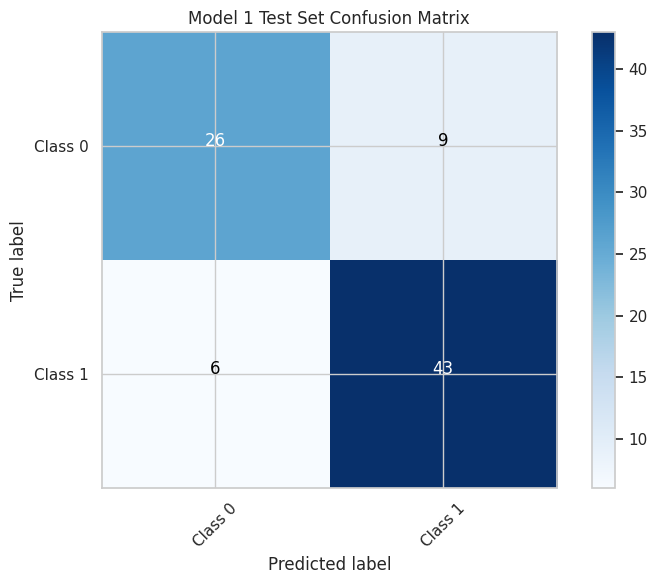

Accuracy: 82.14
Precision: 82.69
Recall: 87.76
F1 Score: 0.851
AUC: 0.897
Loss: 0.414
Plotting history for Model 1...


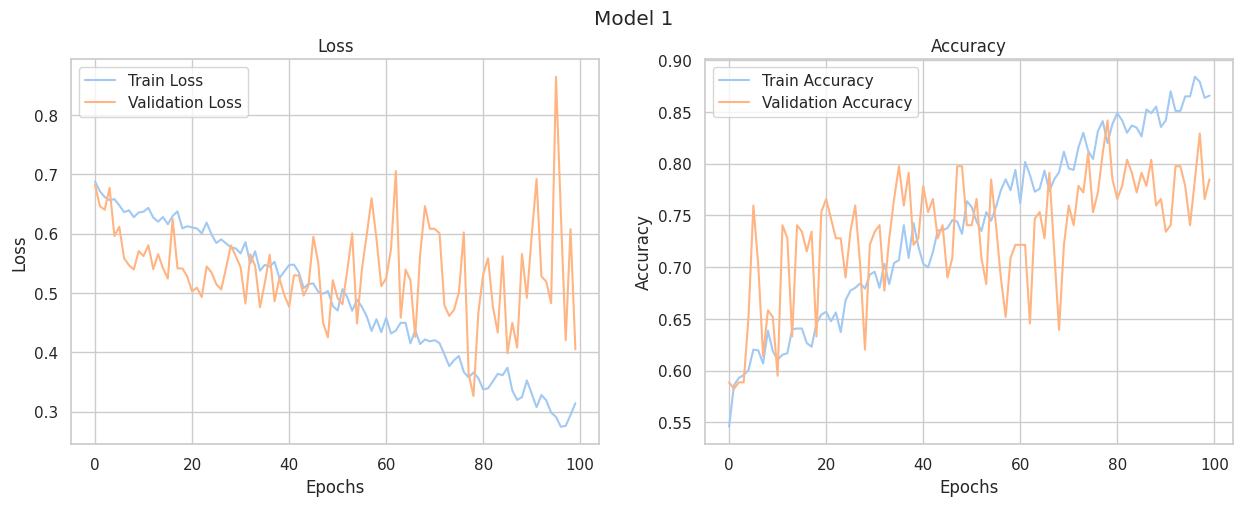

Training Model 2...
Epoch 1/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.4777 - loss: 0.8000
Epoch 1: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.4809 - loss: 0.7942 - val_accuracy: 0.5886 - val_loss: 0.6763
Epoch 2/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5782 - loss: 0.6769
Epoch 2: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5788 - loss: 0.6767 - val_accuracy: 0.5886 - val_loss: 0.6688
Epoch 3/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5532 - loss: 0.6825
Epoch 3: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.5559 - loss: 0.6814 - val_accuracy: 0.5886 - val_loss: 0.6735
Epoch 4/100
18/23 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.5907 - loss: 0.6688
Epoch 4: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.5901 - loss: 0.6675 - val_accuracy: 0.5886 

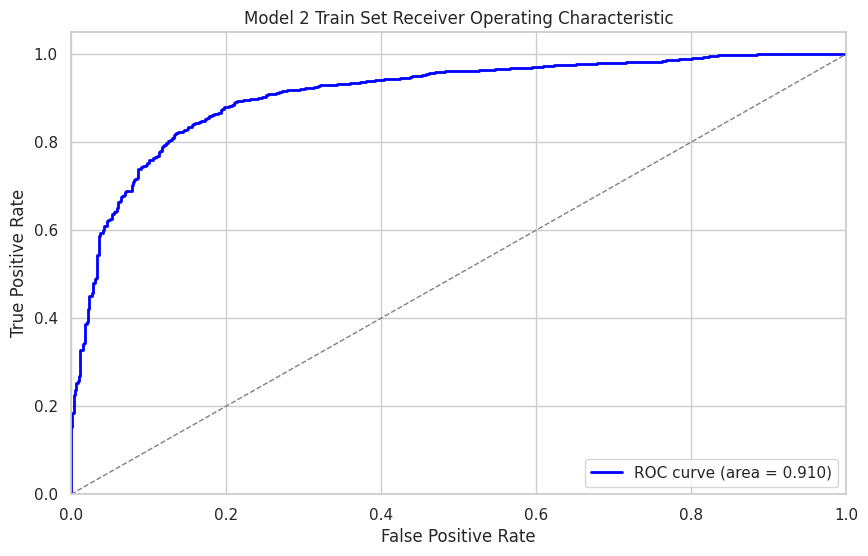

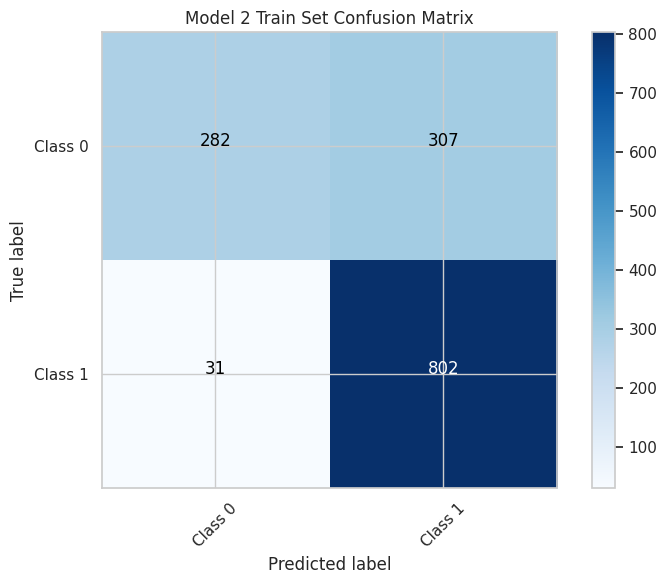

Accuracy: 76.23
Precision: 72.32
Recall: 96.28
F1 Score: 0.826
AUC: 0.910
Loss: 0.480
Evaluating Model 2 on Validation set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7594 - loss: 0.5237 
Test accuracy: 0.753164529800415 Test loss: 0.5411350727081299
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


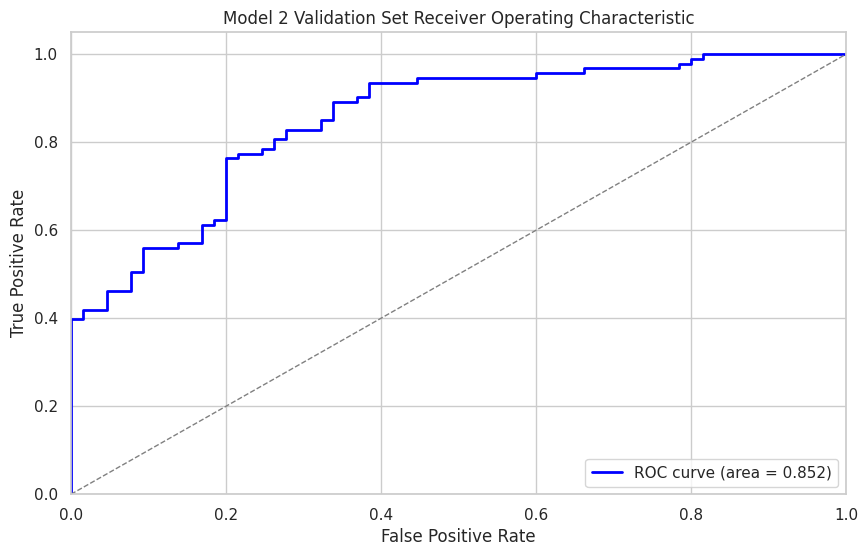

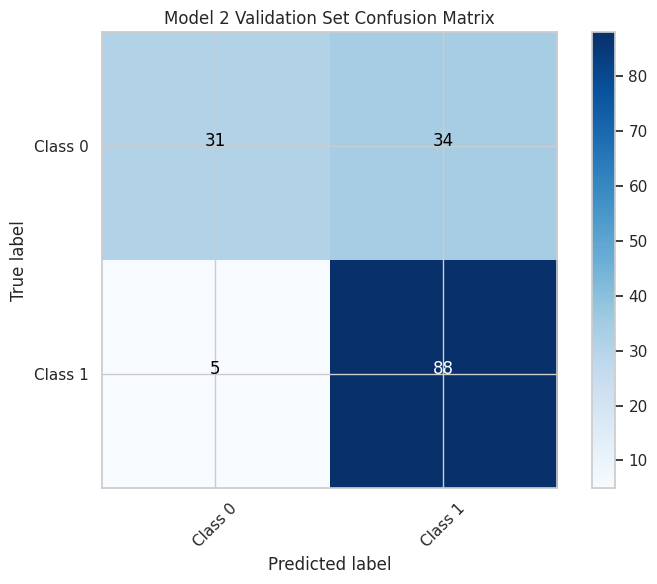

Accuracy: 75.32
Precision: 72.13
Recall: 94.62
F1 Score: 0.819
AUC: 0.852
Loss: 0.541
Evaluating Model 2 on Test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step - accuracy: 0.7237 - loss: 0.7277
Test accuracy: 0.726190447807312 Test loss: 0.72291100025177
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


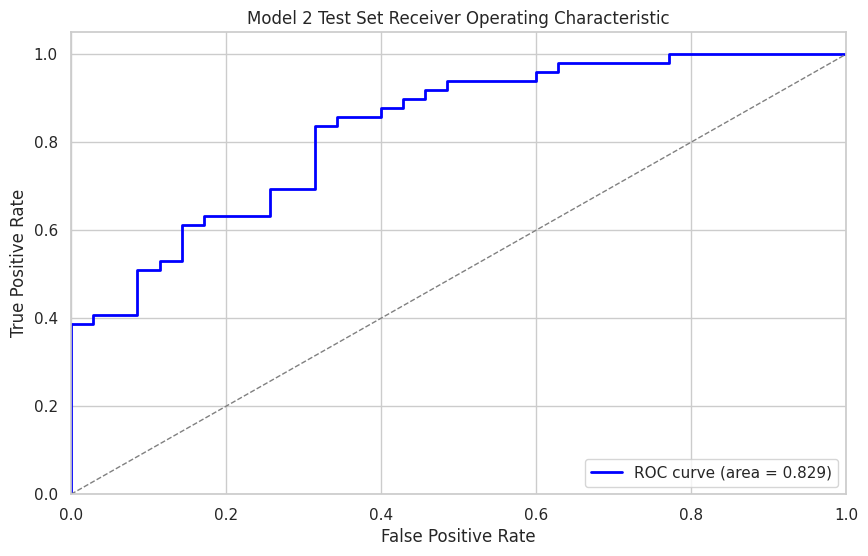

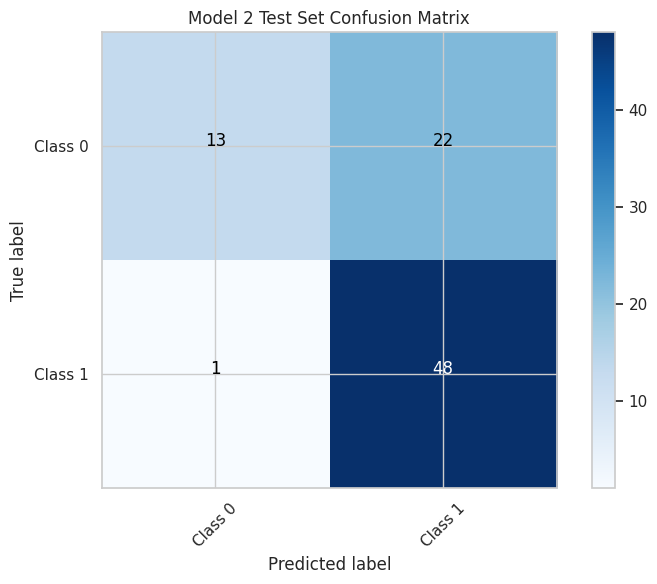

Accuracy: 72.62
Precision: 68.57
Recall: 97.96
F1 Score: 0.807
AUC: 0.829
Loss: 0.723
Plotting history for Model 2...


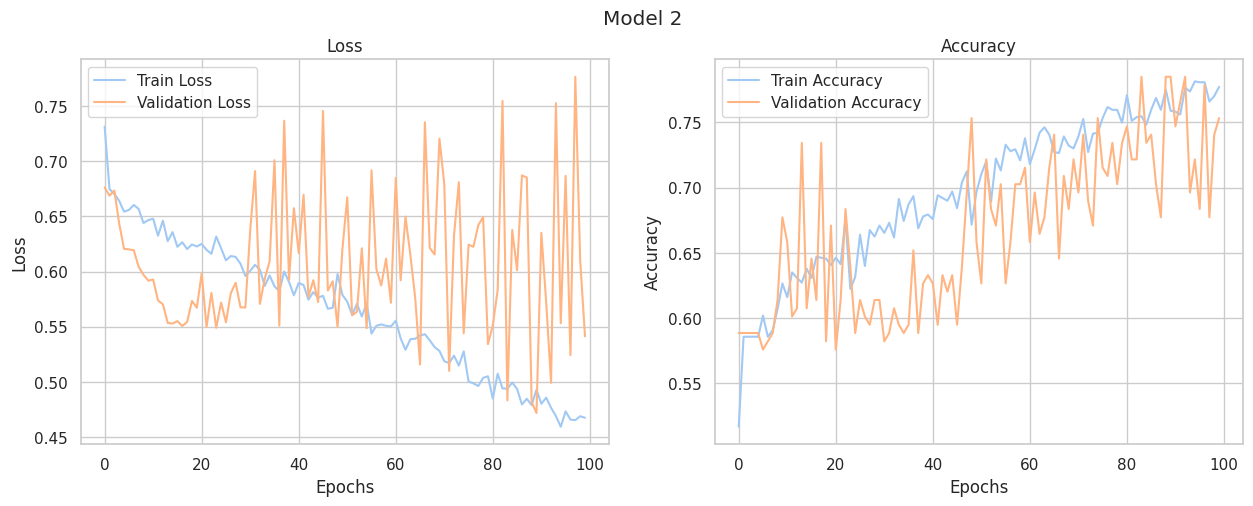

Training Model 3...
Epoch 1/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5025 - loss: 0.7320
Epoch 1: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.5086 - loss: 0.7281 - val_accuracy: 0.5886 - val_loss: 0.6975
Epoch 2/100
20/23 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6016 - loss: 0.6632
Epoch 2: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.5977 - loss: 0.6644 - val_accuracy: 0.5823 - val_loss: 0.6342
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5984 - loss: 0.6632
Epoch 3: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5980 - loss: 0.6633 - val_accuracy: 0.5886 - val_loss: 0.6150
Epoch 4/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6121 - loss: 0.6335
Epoch 4: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.6129 - loss: 0.6334 - val_accuracy: 0.7468 -

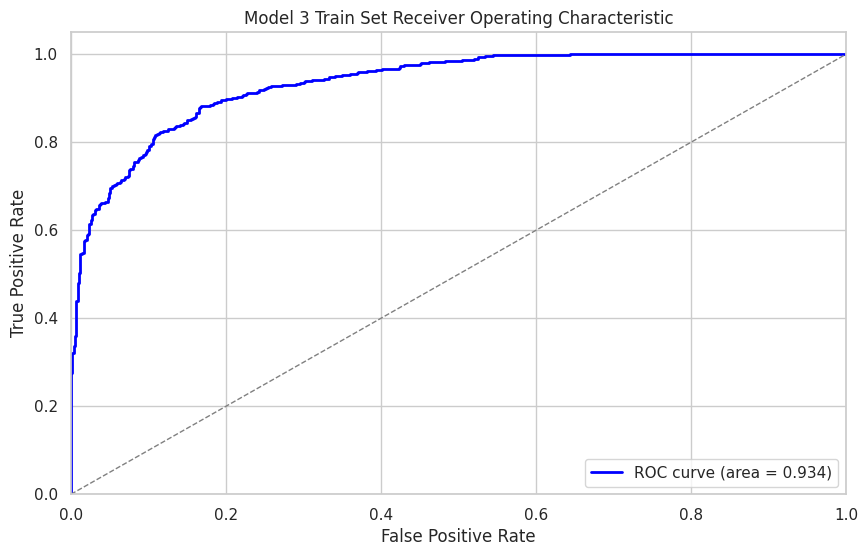

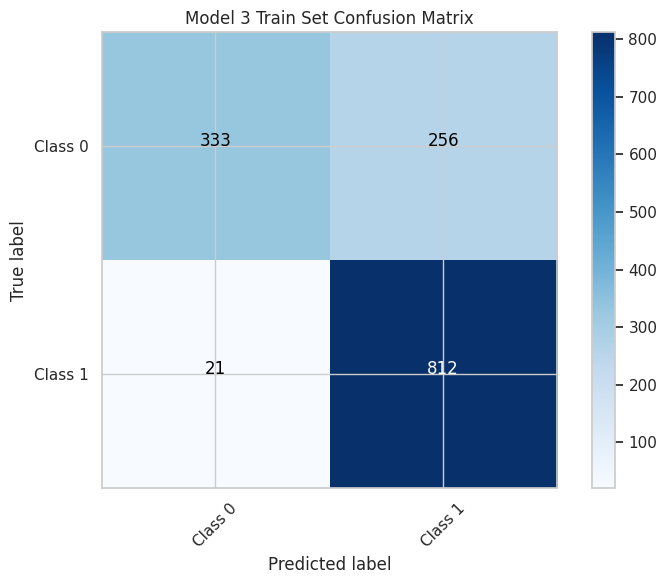

Accuracy: 80.52
Precision: 76.03
Recall: 97.48
F1 Score: 0.854
AUC: 0.934
Loss: 0.409
Evaluating Model 3 on Validation set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7838 - loss: 0.5236 
Test accuracy: 0.7784810066223145 Test loss: 0.5429726839065552
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


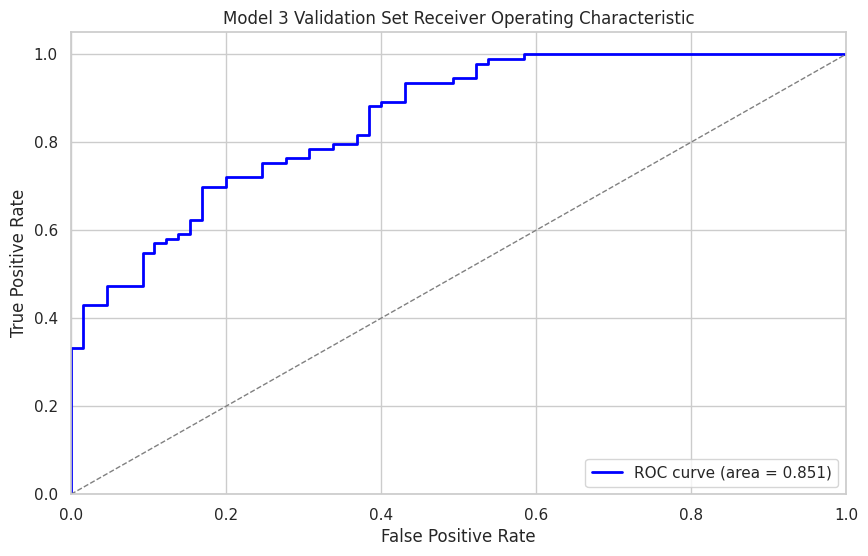

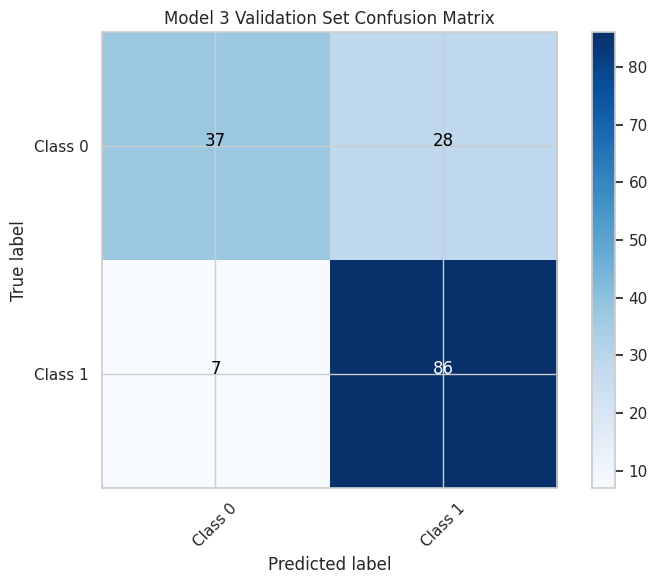

Accuracy: 77.85
Precision: 75.44
Recall: 92.47
F1 Score: 0.831
AUC: 0.851
Loss: 0.543
Evaluating Model 3 on Test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step - accuracy: 0.7316 - loss: 0.6435
Test accuracy: 0.738095223903656 Test loss: 0.6233118772506714
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


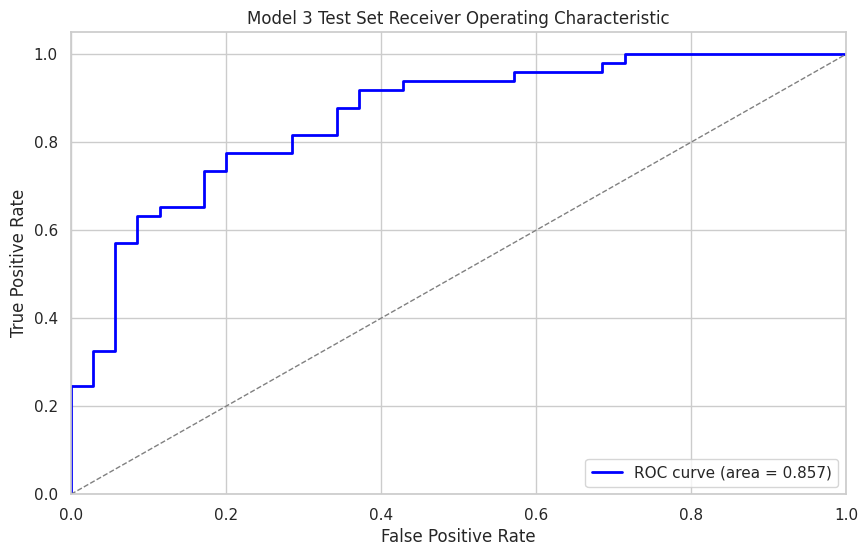

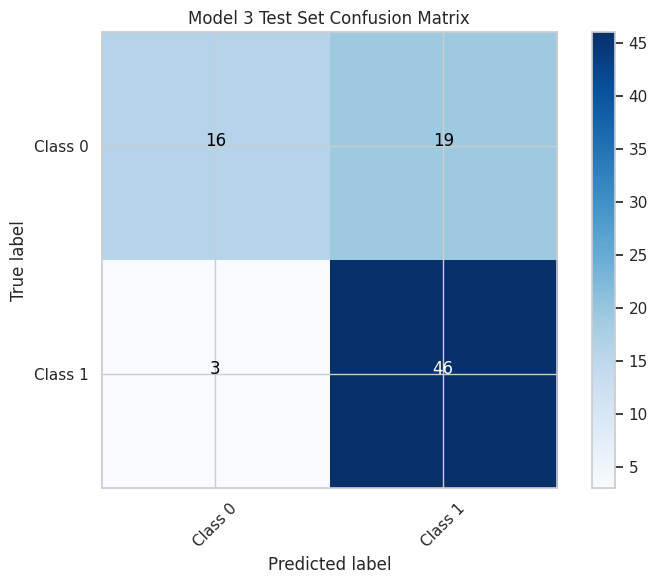

Accuracy: 73.81
Precision: 70.77
Recall: 93.88
F1 Score: 0.807
AUC: 0.857
Loss: 0.623
Plotting history for Model 3...


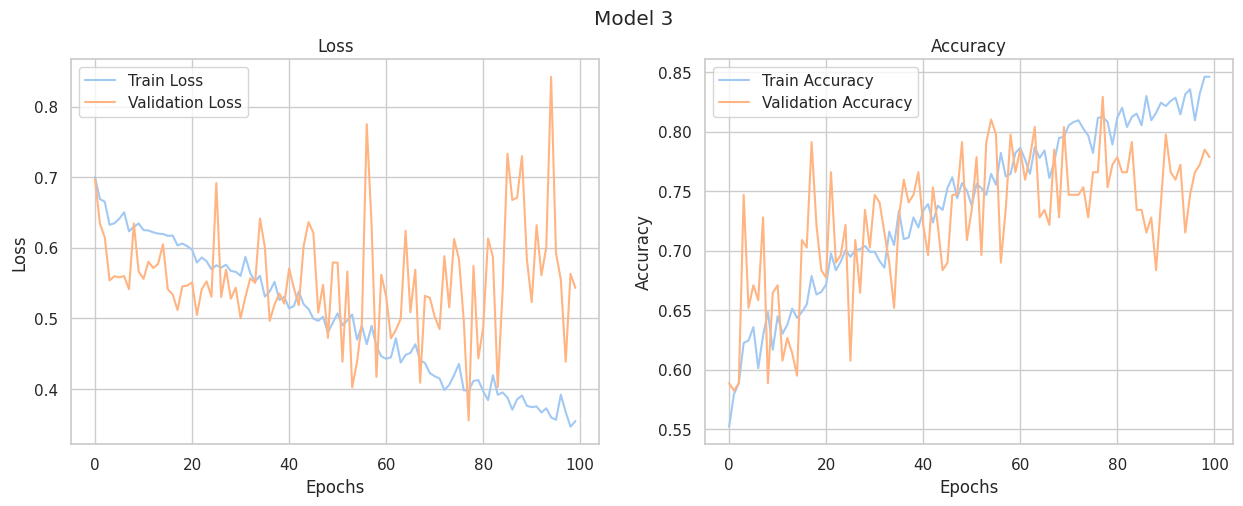

In [ ]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    history = compile_and_train(model, train_generator, val_generator, checkpoint_callback)

    print(f"Evaluating {model_name} on Train set...")
    evaluate_and_plot_confusion_matrix(model_name + ' Train Set', model, train_generator_test, y_train)

    print(f"Evaluating {model_name} on Validation set...")
    evaluate_and_plot_confusion_matrix(model_name + ' Validation Set',model, val_generator, y_val)

    print(f"Evaluating {model_name} on Test set...")
    evaluate_and_plot_confusion_matrix(model_name + ' Test Set',model, test_generator, y_test)

    print(f"Plotting history for {model_name}...")
    plot_history(model_name, history)

# Convolutional Neural Network (CNN) with Dropout Regularization and Glorot Uniform Weight Initialization

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    Dropout(0.2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform()),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 60, 60, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 26, 26, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 10816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │       1,384,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,375,592 (16.69 MB)

 Trainable params: 1,458,530 (5.56 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,917,062 (11.13 MB)

Training Model with DropOut and Glorot Initializer...
Epoch 1/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.5498 - loss: 0.6951
Epoch 1: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 238ms/step - accuracy: 0.5515 - loss: 0.6943 - val_accuracy: 0.5886 - val_loss: 0.6897
Epoch 2/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5802 - loss: 0.6800
Epoch 2: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.5809 - loss: 0.6794 - val_accuracy: 0.5886 - val_loss: 0.6786
Epoch 3/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5868 - loss: 0.6693
Epoch 3: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.5866 - loss: 0.6695 - val_accuracy: 0.5886 - val_loss: 0.6666
Epoch 4/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5868 - loss: 0.6636 
Epoch 4: val_loss did not improve from 0.32618
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.5863 - l

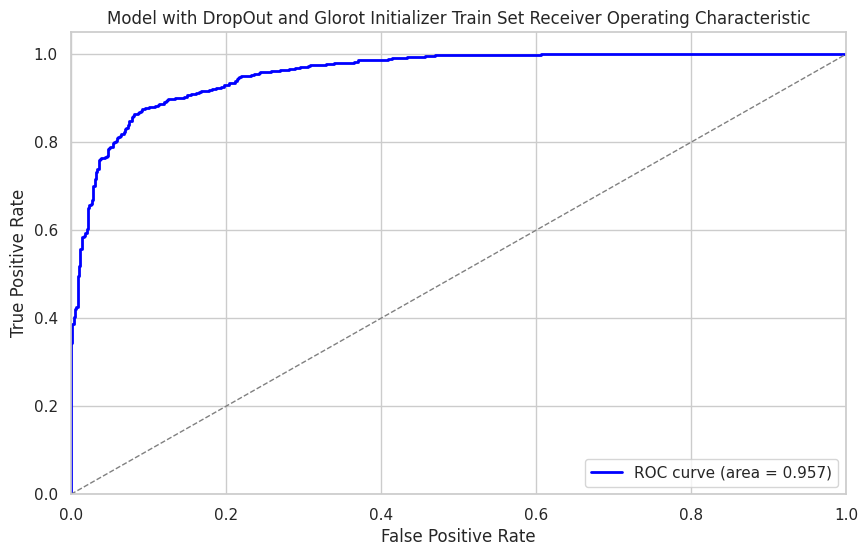

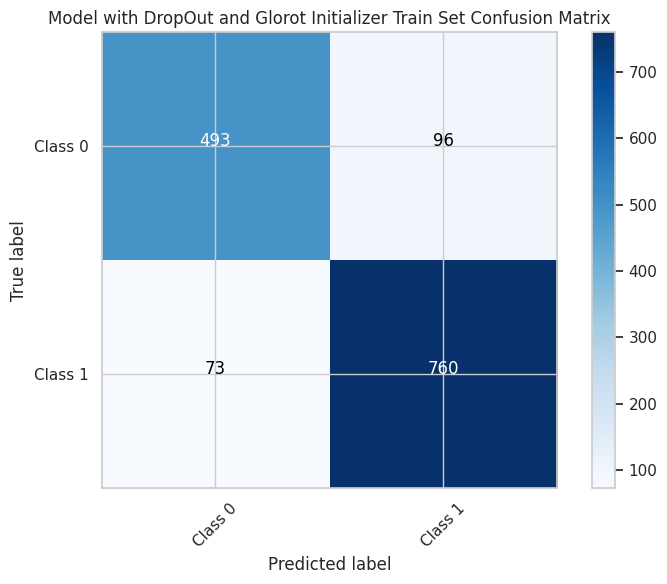

Accuracy: 88.12
Precision: 88.79
Recall: 91.24
F1 Score: 0.900
AUC: 0.957
Loss: 0.287
Evaluating Model with DropOut and Glorot Initializer on Validation set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7803 - loss: 0.4055
Test accuracy: 0.7911392450332642 Test loss: 0.3887379467487335
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


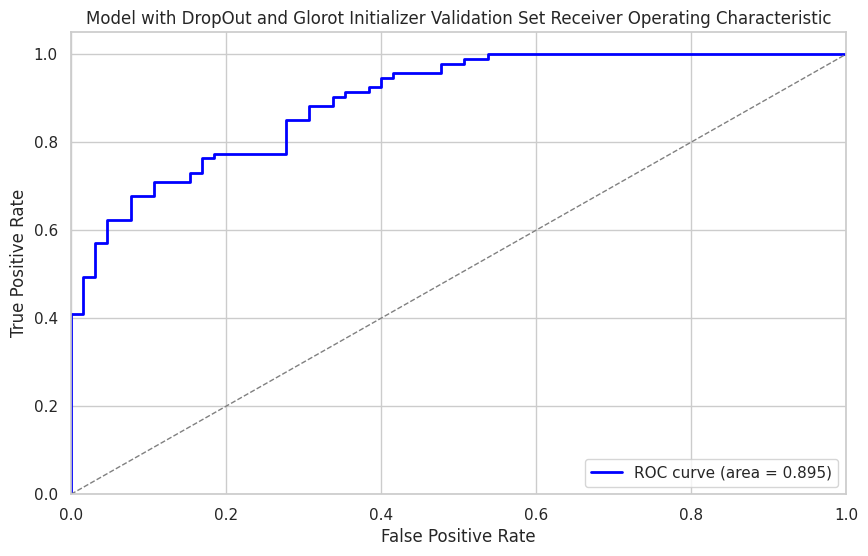

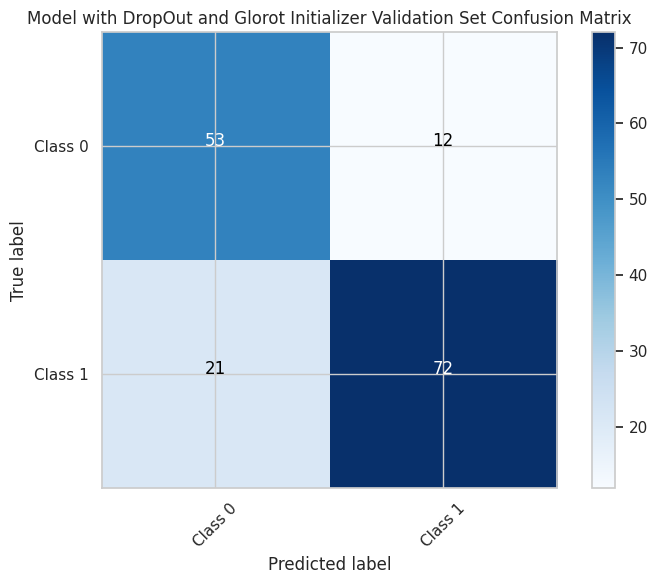

Accuracy: 79.11
Precision: 85.71
Recall: 77.42
F1 Score: 0.814
AUC: 0.895
Loss: 0.389
Evaluating Model with DropOut and Glorot Initializer on Test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step - accuracy: 0.8185 - loss: 0.3458
Test accuracy: 0.8214285969734192 Test loss: 0.3344825208187103
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


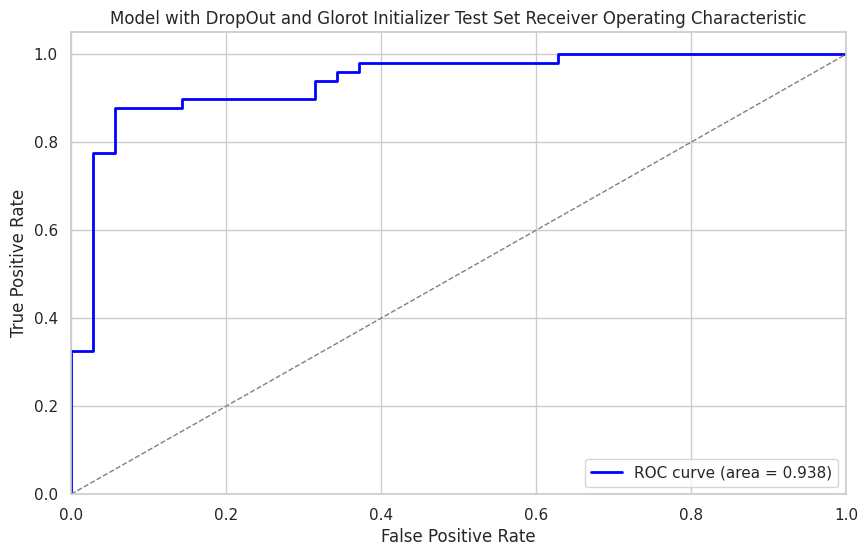

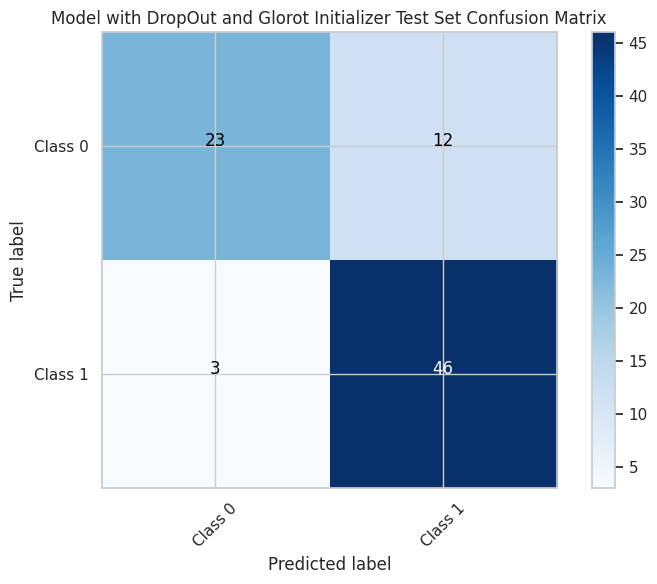

Accuracy: 82.14
Precision: 79.31
Recall: 93.88
F1 Score: 0.860
AUC: 0.938
Loss: 0.334
Plotting history for Model with DropOut and Glorot Initializer...


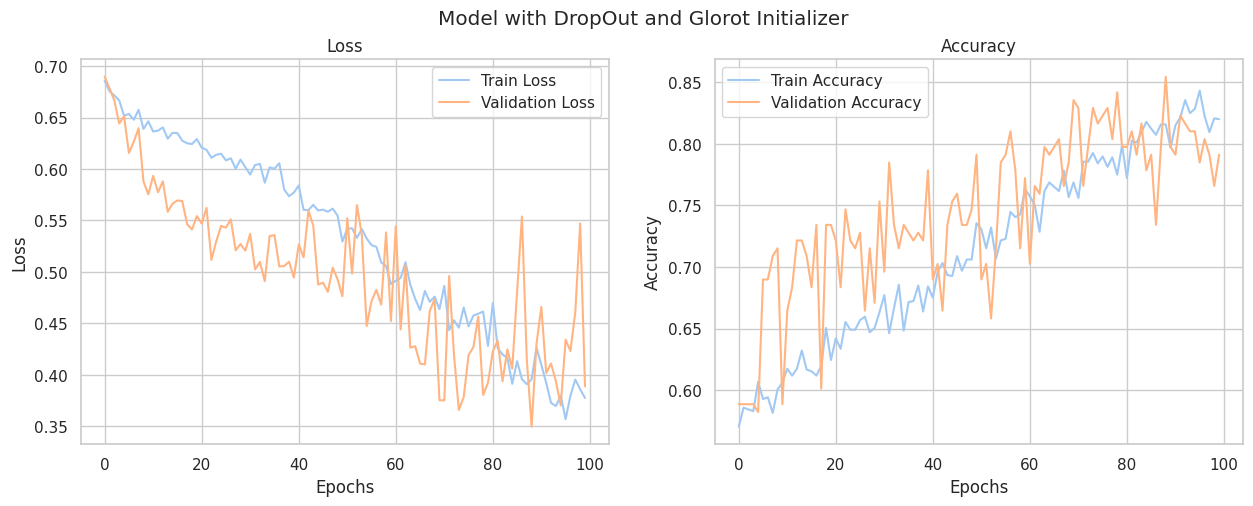

In [ ]:
model_name = 'Model with DropOut and Glorot Initializer'
print(f"Training {model_name}...")
history = compile_and_train(model, train_generator, val_generator, checkpoint_callback)

print(f"Evaluating {model_name} on Train set...")
evaluate_and_plot_confusion_matrix(model_name + ' Train Set', model, train_generator_test, y_train)

print(f"Evaluating {model_name} on Validation set...")
evaluate_and_plot_confusion_matrix(model_name + ' Validation Set',model, val_generator, y_val)

print(f"Evaluating {model_name} on Test set...")
evaluate_and_plot_confusion_matrix(model_name + ' Test Set',model, test_generator, y_test)

print(f"Plotting history for {model_name}...")
plot_history(model_name, history)

# Install required libraries

In [ ]:
!pip install diffusers transformers accelerate torch


# Load the Stable Diffusion model

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

# Load the Stable Diffusion model
model_id = "runwayml/stable-diffusion-v1-5"  # You can use other versions like "stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)

# Move the model to GPU (if available)
pipe = pipe.to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

# Generate Images from Text Prompts

In [ ]:
# Define a text prompt
prompt = "A futuristic cityscape at sunset, with flying cars and neon lights"

# Generate the image
image = pipe(prompt).images[0]

# Display the image
image.show()

  0%|          | 0/50 [00:00<?, ?it/s]

# Save the Generated Image

In [ ]:
# Save the image
image.save("generated_image.png")

# If using Google Colab, save to Google Drive
from google.colab import drive
drive.mount('/content/drive')

image.save("/content/drive/MyDrive/generated_image.png")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Customize Image Generation

In [ ]:
# Generate an image with custom parameters
image = pipe(
    prompt,
    num_inference_steps=50,  # Increase for better quality
    guidance_scale=7.5,      # Adjust for prompt adherence
    generator=torch.Generator("cuda").manual_seed(42)  # Set a seed for reproducibility
).images[0]

# Display the image
image.show()

  0%|          | 0/50 [00:00<?, ?it/s]

# Generate Multiple Images

In [ ]:
# Generate 4 images
images = pipe(
    prompt,
    num_images_per_prompt=4,
    num_inference_steps=50,
    guidance_scale=7.5
).images

# Display the images
for i, img in enumerate(images):
    img.show()
    img.save(f"generated_image_{i+1}.png")

  0%|          | 0/50 [00:00<?, ?it/s]

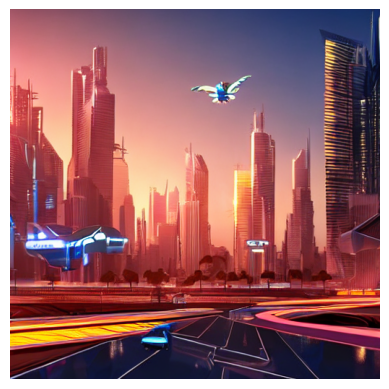

In [ ]:
# Display the image using matplotlib
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis('off')  # Hide the axes
plt.show()

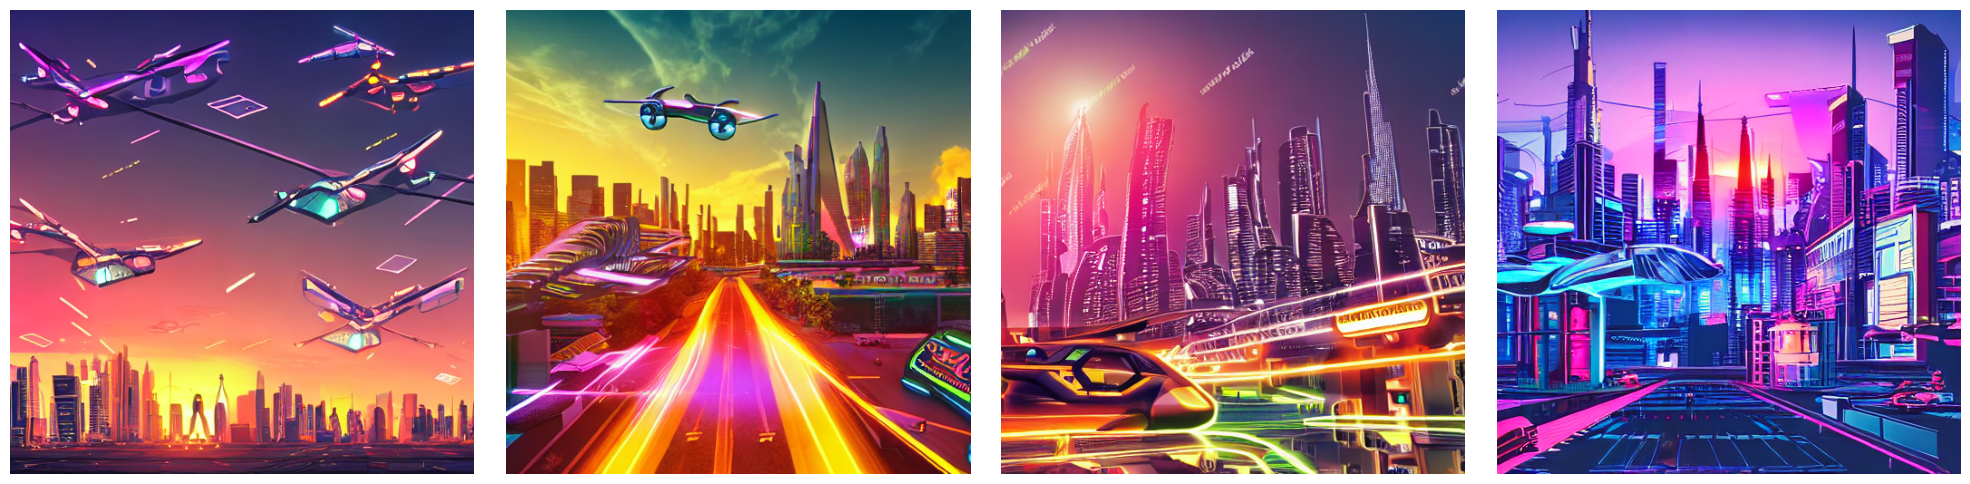

In [ ]:
# Display the images in a grid
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(images), figsize=(20, 5))

for i, img in enumerate(images):
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide the axes

plt.tight_layout()
plt.show()

# Diffusion Model for Alzheimer's Classification

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm

class DiffusionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # U-Net style architecture for the diffusion model
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.middle = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, padding=1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    def forward(self, x, t):
        # t is the diffusion timestep
        t = t.view(-1, 1, 1, 1)
        x = x + torch.randn_like(x) * t  # Add noise based on timestep

        # Encoder path
        features = self.encoder(x)

        # Middle blocks
        features = self.middle(features)

        # Classification path
        class_features = features.view(features.size(0), -1)
        classification = self.classifier(class_features)

        # Decoder path for reconstruction
        reconstruction = self.decoder(features)

        return classification, reconstruction

def train_diffusion_model(images, labels, batch_size=32, num_epochs=100):
    # Convert data format from NHWC to NCHW (TensorFlow to PyTorch)
    X = np.transpose(images, (0, 3, 1, 2))

    # Convert data to PyTorch tensors
    X = torch.FloatTensor(X) / 255.0  # Normalize to [0,1]
    y = torch.FloatTensor(labels)

    # Create dataset and dataloader
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model and optimizer
    model = DiffusionModel()
    if torch.cuda.is_available():
        model = model.cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_x, batch_y in tqdm(dataloader):
            if torch.cuda.is_available():
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()

            # Sample random timesteps
            t = torch.rand(batch_x.size(0), 1).to(batch_x.device)

            # Forward pass
            class_pred, reconstruction = model(batch_x, t)

            # Calculate losses
            classification_loss = F.cross_entropy(class_pred, batch_y.argmax(1))
            reconstruction_loss = F.mse_loss(reconstruction, batch_x)

            # Combined loss
            loss = classification_loss + 0.1 * reconstruction_loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    return model

def evaluate_diffusion_model(model, test_images, test_labels, batch_size=32):
    model.eval()
    # Convert data format from NHWC to NCHW
    X_test = np.transpose(test_images, (0, 3, 1, 2))
    X_test = torch.FloatTensor(X_test) / 255.0
    y_test = torch.FloatTensor(test_labels)

    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    correct = 0
    total = 0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            if torch.cuda.is_available():
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()

            t = torch.zeros(batch_x.size(0), 1).to(batch_x.device)  # Use t=0 for evaluation
            class_pred, _ = model(batch_x, t)

            _, predicted = torch.max(class_pred.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y.argmax(1)).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Example usage:
print("Training diffusion model...")
diffusion_model = train_diffusion_model(X_train, y_train)

print("\nEvaluating on test set...")
test_accuracy = evaluate_diffusion_model(diffusion_model, X_test, y_test)

Training diffusion model...


100%|██████████| 45/45 [00:03<00:00, 14.17it/s]


Epoch 1/100, Loss: 0.6875


100%|██████████| 45/45 [00:02<00:00, 18.13it/s]


Epoch 2/100, Loss: 0.6859


100%|██████████| 45/45 [00:02<00:00, 18.36it/s]


Epoch 3/100, Loss: 0.6802


100%|██████████| 45/45 [00:02<00:00, 18.35it/s]


Epoch 4/100, Loss: 0.6816


100%|██████████| 45/45 [00:02<00:00, 18.26it/s]


Epoch 5/100, Loss: 0.6688


100%|██████████| 45/45 [00:02<00:00, 18.23it/s]


Epoch 6/100, Loss: 0.6313


100%|██████████| 45/45 [00:02<00:00, 17.95it/s]


Epoch 7/100, Loss: 0.6434


100%|██████████| 45/45 [00:02<00:00, 18.21it/s]


Epoch 8/100, Loss: 0.6124


100%|██████████| 45/45 [00:02<00:00, 18.29it/s]


Epoch 9/100, Loss: 0.6008


100%|██████████| 45/45 [00:02<00:00, 18.22it/s]


Epoch 10/100, Loss: 0.5800


100%|██████████| 45/45 [00:02<00:00, 18.25it/s]


Epoch 11/100, Loss: 0.5514


100%|██████████| 45/45 [00:02<00:00, 17.97it/s]


Epoch 12/100, Loss: 0.5610


100%|██████████| 45/45 [00:02<00:00, 17.91it/s]


Epoch 13/100, Loss: 0.5570


100%|██████████| 45/45 [00:02<00:00, 18.18it/s]


Epoch 14/100, Loss: 0.5355


100%|██████████| 45/45 [00:02<00:00, 18.16it/s]


Epoch 15/100, Loss: 0.5294


100%|██████████| 45/45 [00:02<00:00, 18.11it/s]


Epoch 16/100, Loss: 0.5447


100%|██████████| 45/45 [00:02<00:00, 18.08it/s]


Epoch 17/100, Loss: 0.5186


100%|██████████| 45/45 [00:02<00:00, 17.79it/s]


Epoch 18/100, Loss: 0.5115


100%|██████████| 45/45 [00:02<00:00, 17.88it/s]


Epoch 19/100, Loss: 0.4878


100%|██████████| 45/45 [00:02<00:00, 18.05it/s]


Epoch 20/100, Loss: 0.4780


100%|██████████| 45/45 [00:02<00:00, 18.03it/s]


Epoch 21/100, Loss: 0.4855


100%|██████████| 45/45 [00:02<00:00, 17.94it/s]


Epoch 22/100, Loss: 0.4762


100%|██████████| 45/45 [00:02<00:00, 17.83it/s]


Epoch 23/100, Loss: 0.4678


100%|██████████| 45/45 [00:02<00:00, 17.65it/s]


Epoch 24/100, Loss: 0.4493


100%|██████████| 45/45 [00:02<00:00, 17.88it/s]


Epoch 25/100, Loss: 0.4167


100%|██████████| 45/45 [00:02<00:00, 17.87it/s]


Epoch 26/100, Loss: 0.4321


100%|██████████| 45/45 [00:02<00:00, 17.83it/s]


Epoch 27/100, Loss: 0.4261


100%|██████████| 45/45 [00:02<00:00, 17.81it/s]


Epoch 28/100, Loss: 0.4058


100%|██████████| 45/45 [00:02<00:00, 17.54it/s]


Epoch 29/100, Loss: 0.3771


100%|██████████| 45/45 [00:02<00:00, 17.54it/s]


Epoch 30/100, Loss: 0.3732


100%|██████████| 45/45 [00:02<00:00, 17.66it/s]


Epoch 31/100, Loss: 0.3536


100%|██████████| 45/45 [00:02<00:00, 17.68it/s]


Epoch 32/100, Loss: 0.3554


100%|██████████| 45/45 [00:02<00:00, 17.69it/s]


Epoch 33/100, Loss: 0.3589


100%|██████████| 45/45 [00:02<00:00, 17.59it/s]


Epoch 34/100, Loss: 0.3342


100%|██████████| 45/45 [00:02<00:00, 17.44it/s]


Epoch 35/100, Loss: 0.3253


100%|██████████| 45/45 [00:02<00:00, 17.59it/s]


Epoch 36/100, Loss: 0.3446


100%|██████████| 45/45 [00:02<00:00, 17.61it/s]


Epoch 37/100, Loss: 0.3063


100%|██████████| 45/45 [00:02<00:00, 17.64it/s]


Epoch 38/100, Loss: 0.3011


100%|██████████| 45/45 [00:02<00:00, 17.66it/s]


Epoch 39/100, Loss: 0.2789


100%|██████████| 45/45 [00:02<00:00, 17.41it/s]


Epoch 40/100, Loss: 0.2771


100%|██████████| 45/45 [00:02<00:00, 17.51it/s]


Epoch 41/100, Loss: 0.2580


100%|██████████| 45/45 [00:02<00:00, 17.77it/s]


Epoch 42/100, Loss: 0.2757


100%|██████████| 45/45 [00:02<00:00, 17.73it/s]


Epoch 43/100, Loss: 0.2793


100%|██████████| 45/45 [00:02<00:00, 17.70it/s]


Epoch 44/100, Loss: 0.2562


100%|██████████| 45/45 [00:02<00:00, 17.58it/s]


Epoch 45/100, Loss: 0.2514


100%|██████████| 45/45 [00:02<00:00, 17.52it/s]


Epoch 46/100, Loss: 0.2525


100%|██████████| 45/45 [00:02<00:00, 17.71it/s]


Epoch 47/100, Loss: 0.2462


100%|██████████| 45/45 [00:02<00:00, 17.80it/s]


Epoch 48/100, Loss: 0.2438


100%|██████████| 45/45 [00:02<00:00, 17.74it/s]


Epoch 49/100, Loss: 0.2128


100%|██████████| 45/45 [00:02<00:00, 17.79it/s]


Epoch 50/100, Loss: 0.2127


100%|██████████| 45/45 [00:02<00:00, 17.60it/s]


Epoch 51/100, Loss: 0.2247


100%|██████████| 45/45 [00:02<00:00, 17.59it/s]


Epoch 52/100, Loss: 0.2024


100%|██████████| 45/45 [00:02<00:00, 17.76it/s]


Epoch 53/100, Loss: 0.2198


100%|██████████| 45/45 [00:02<00:00, 17.84it/s]


Epoch 54/100, Loss: 0.2131


100%|██████████| 45/45 [00:02<00:00, 17.84it/s]


Epoch 55/100, Loss: 0.2097


100%|██████████| 45/45 [00:02<00:00, 17.67it/s]


Epoch 56/100, Loss: 0.2177


100%|██████████| 45/45 [00:02<00:00, 17.51it/s]


Epoch 57/100, Loss: 0.2040


100%|██████████| 45/45 [00:02<00:00, 17.81it/s]


Epoch 58/100, Loss: 0.1951


100%|██████████| 45/45 [00:02<00:00, 17.84it/s]


Epoch 59/100, Loss: 0.1866


100%|██████████| 45/45 [00:02<00:00, 17.82it/s]


Epoch 60/100, Loss: 0.1739


100%|██████████| 45/45 [00:02<00:00, 17.82it/s]


Epoch 61/100, Loss: 0.1715


100%|██████████| 45/45 [00:02<00:00, 17.52it/s]


Epoch 62/100, Loss: 0.2062


100%|██████████| 45/45 [00:02<00:00, 17.57it/s]


Epoch 63/100, Loss: 0.1885


100%|██████████| 45/45 [00:02<00:00, 17.79it/s]


Epoch 64/100, Loss: 0.1836


100%|██████████| 45/45 [00:02<00:00, 17.80it/s]


Epoch 65/100, Loss: 0.1833


100%|██████████| 45/45 [00:02<00:00, 17.83it/s]


Epoch 66/100, Loss: 0.1791


100%|██████████| 45/45 [00:02<00:00, 17.72it/s]


Epoch 67/100, Loss: 0.1670


100%|██████████| 45/45 [00:02<00:00, 17.49it/s]


Epoch 68/100, Loss: 0.1583


100%|██████████| 45/45 [00:02<00:00, 17.75it/s]


Epoch 69/100, Loss: 0.1828


100%|██████████| 45/45 [00:02<00:00, 17.78it/s]


Epoch 70/100, Loss: 0.1788


100%|██████████| 45/45 [00:02<00:00, 17.74it/s]


Epoch 71/100, Loss: 0.1710


100%|██████████| 45/45 [00:02<00:00, 17.74it/s]


Epoch 72/100, Loss: 0.1713


100%|██████████| 45/45 [00:02<00:00, 17.47it/s]


Epoch 73/100, Loss: 0.1537


100%|██████████| 45/45 [00:02<00:00, 17.55it/s]


Epoch 74/100, Loss: 0.1568


100%|██████████| 45/45 [00:02<00:00, 17.71it/s]


Epoch 75/100, Loss: 0.1681


100%|██████████| 45/45 [00:02<00:00, 17.72it/s]


Epoch 76/100, Loss: 0.1781


100%|██████████| 45/45 [00:02<00:00, 17.69it/s]


Epoch 77/100, Loss: 0.1684


100%|██████████| 45/45 [00:02<00:00, 17.57it/s]


Epoch 78/100, Loss: 0.1531


100%|██████████| 45/45 [00:02<00:00, 17.42it/s]


Epoch 79/100, Loss: 0.1364


100%|██████████| 45/45 [00:02<00:00, 17.70it/s]


Epoch 80/100, Loss: 0.1560


100%|██████████| 45/45 [00:02<00:00, 17.71it/s]


Epoch 81/100, Loss: 0.1450


100%|██████████| 45/45 [00:02<00:00, 17.68it/s]


Epoch 82/100, Loss: 0.1428


100%|██████████| 45/45 [00:02<00:00, 17.62it/s]


Epoch 83/100, Loss: 0.1369


100%|██████████| 45/45 [00:02<00:00, 17.41it/s]


Epoch 84/100, Loss: 0.1460


100%|██████████| 45/45 [00:02<00:00, 17.57it/s]


Epoch 85/100, Loss: 0.1710


100%|██████████| 45/45 [00:02<00:00, 17.70it/s]


Epoch 86/100, Loss: 0.1469


100%|██████████| 45/45 [00:02<00:00, 17.72it/s]


Epoch 87/100, Loss: 0.1197


100%|██████████| 45/45 [00:02<00:00, 17.75it/s]


Epoch 88/100, Loss: 0.1434


100%|██████████| 45/45 [00:02<00:00, 17.63it/s]


Epoch 89/100, Loss: 0.1315


100%|██████████| 45/45 [00:02<00:00, 17.38it/s]


Epoch 90/100, Loss: 0.1406


100%|██████████| 45/45 [00:02<00:00, 17.78it/s]


Epoch 91/100, Loss: 0.1431


100%|██████████| 45/45 [00:02<00:00, 17.79it/s]


Epoch 92/100, Loss: 0.1395


100%|██████████| 45/45 [00:02<00:00, 17.82it/s]


Epoch 93/100, Loss: 0.1576


100%|██████████| 45/45 [00:02<00:00, 17.84it/s]


Epoch 94/100, Loss: 0.1266


100%|██████████| 45/45 [00:02<00:00, 17.52it/s]


Epoch 95/100, Loss: 0.1355


100%|██████████| 45/45 [00:02<00:00, 17.70it/s]


Epoch 96/100, Loss: 0.1516


100%|██████████| 45/45 [00:02<00:00, 17.81it/s]


Epoch 97/100, Loss: 0.1469


100%|██████████| 45/45 [00:02<00:00, 17.84it/s]


Epoch 98/100, Loss: 0.1299


100%|██████████| 45/45 [00:02<00:00, 17.81it/s]


Epoch 99/100, Loss: 0.1191


100%|██████████| 45/45 [00:02<00:00, 17.70it/s]


Epoch 100/100, Loss: 0.1119

Evaluating on test set...
Test Accuracy: 98.81%


Performing comprehensive evaluation...


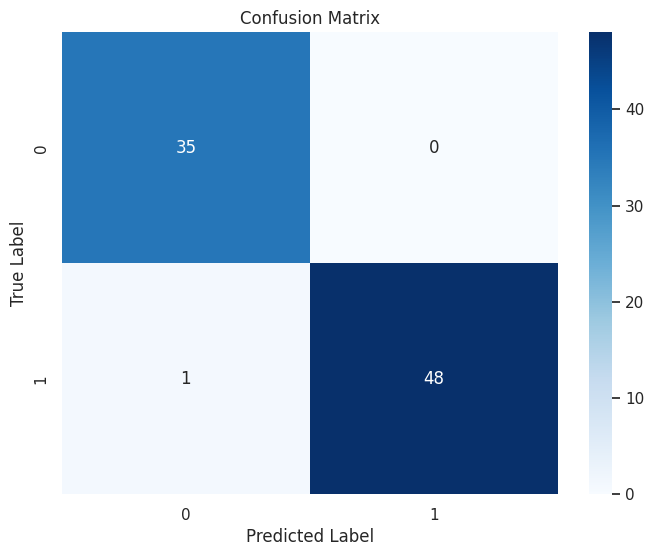

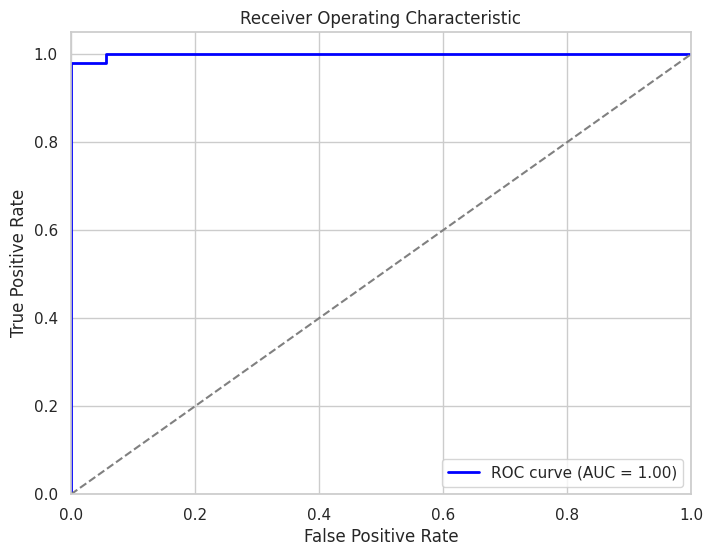

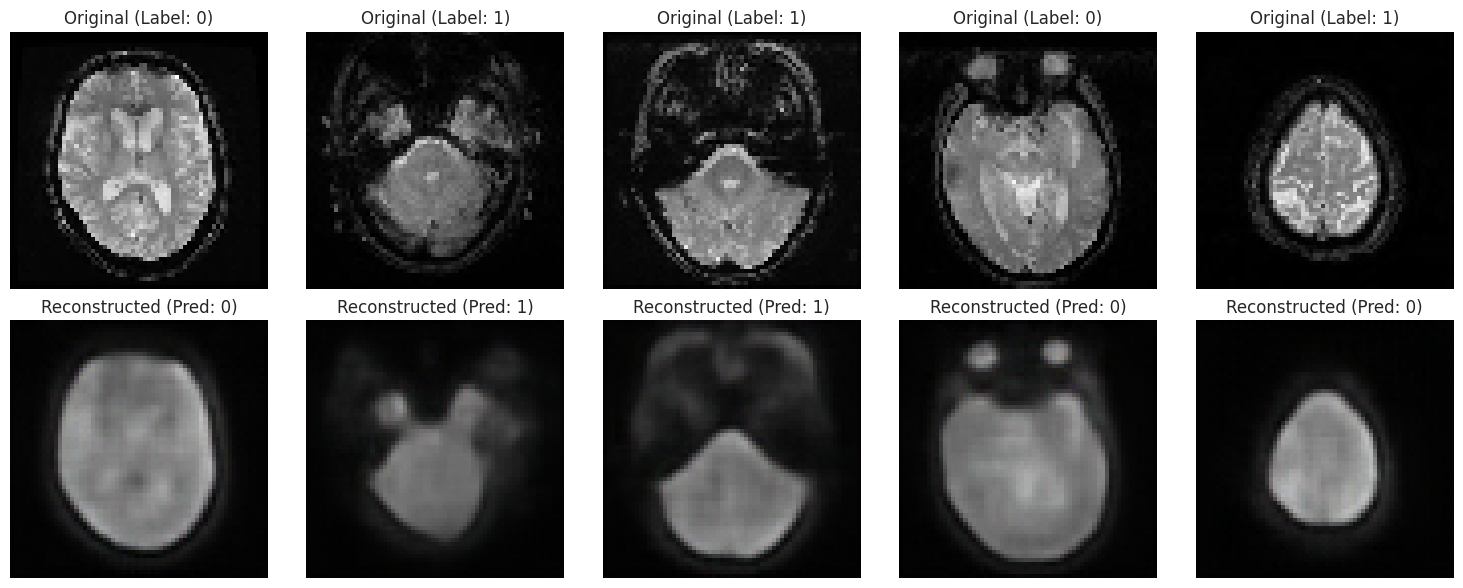

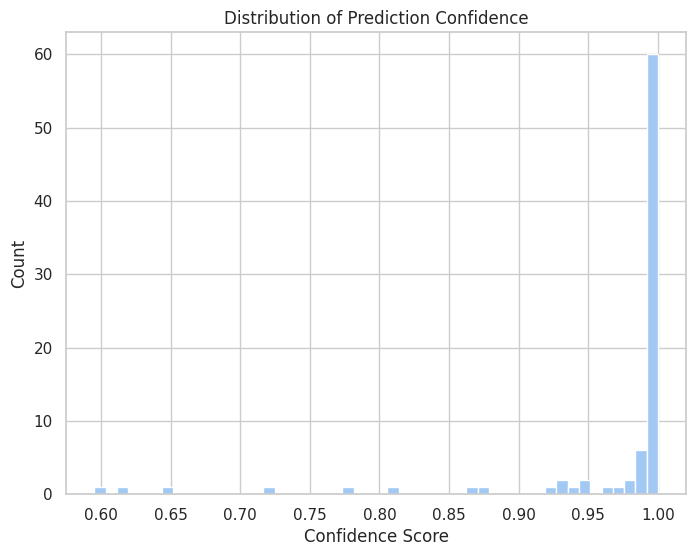


Detailed Evaluation Metrics:
Accuracy: 0.9881
Precision: 1.0000
Recall: 0.9796
F1 Score: 0.9897
ROC AUC: 0.9988

Confusion Matrix:
[[35  0]
 [ 1 48]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        35
           1       1.00      0.98      0.99        49

    accuracy                           0.99        84
   macro avg       0.99      0.99      0.99        84
weighted avg       0.99      0.99      0.99        84

Fold 1 Accuracy: 0.9412
Fold 2 Accuracy: 1.0000
Fold 3 Accuracy: 1.0000
Fold 4 Accuracy: 1.0000
Fold 5 Accuracy: 1.0000

Cross-validation mean accuracy: 0.9882 (±0.0235)


In [ ]:
def evaluate_diffusion_model_comprehensive(model, test_images, test_labels, batch_size=32):
    model.eval()
    # Convert data format from NHWC to NCHW
    X_test = np.transpose(test_images, (0, 3, 1, 2))
    X_test = torch.FloatTensor(X_test) / 255.0
    y_test = torch.FloatTensor(test_labels)

    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize lists to store predictions and true labels
    all_predictions = []
    all_probabilities = []
    all_true_labels = []
    all_reconstructions = []
    all_original_images = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            if torch.cuda.is_available():
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()

            t = torch.zeros(batch_x.size(0), 1).to(batch_x.device)
            class_pred, reconstruction = model(batch_x, t)

            # Store predictions, probabilities, and true labels
            probabilities = F.softmax(class_pred, dim=1)
            predictions = torch.argmax(class_pred, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_true_labels.extend(batch_y.argmax(1).cpu().numpy())
            all_reconstructions.extend(reconstruction.cpu().numpy())
            all_original_images.extend(batch_x.cpu().numpy())

    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)
    all_true_labels = np.array(all_true_labels)

    # Calculate metrics
    accuracy = accuracy_score(all_true_labels, all_predictions)
    precision = precision_score(all_true_labels, all_predictions)
    recall = recall_score(all_true_labels, all_predictions)
    f1 = f1_score(all_true_labels, all_predictions)
    conf_matrix = confusion_matrix(all_true_labels, all_predictions)

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_true_labels, all_probabilities[:, 1])
    roc_auc = auc(fpr, tpr)

    # Calculate per-class metrics
    class_report = classification_report(all_true_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Plot sample reconstructions
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(5):
        # Original image
        axes[0, i].imshow(np.transpose(all_original_images[i], (1, 2, 0)))
        axes[0, i].set_title(f'Original (Label: {all_true_labels[i]})')
        axes[0, i].axis('off')

        # Reconstructed image
        axes[1, i].imshow(np.transpose(all_reconstructions[i], (1, 2, 0)))
        axes[1, i].set_title(f'Reconstructed (Pred: {all_predictions[i]})')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

    # Calculate prediction confidence distribution
    confidence_scores = np.max(all_probabilities, axis=1)
    plt.figure(figsize=(8, 6))
    plt.hist(confidence_scores, bins=50)
    plt.title('Distribution of Prediction Confidence')
    plt.xlabel('Confidence Score')
    plt.ylabel('Count')
    plt.show()

    # Print detailed metrics
    print("\nDetailed Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

    # Calculate cross-validation scores
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_test)):
        X_fold = X_test[val_idx]
        y_fold = y_test[val_idx]

        fold_dataset = TensorDataset(X_fold, y_fold)
        fold_loader = DataLoader(fold_dataset, batch_size=batch_size)

        correct = 0
        total = 0

        with torch.no_grad():
            for batch_x, batch_y in fold_loader:
                if torch.cuda.is_available():
                    batch_x = batch_x.cuda()
                    batch_y = batch_y.cuda()

                t = torch.zeros(batch_x.size(0), 1).to(batch_x.device)
                class_pred, _ = model(batch_x, t)

                _, predicted = torch.max(class_pred.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y.argmax(1)).sum().item()

        fold_accuracy = correct / total
        cv_scores.append(fold_accuracy)
        print(f"Fold {fold + 1} Accuracy: {fold_accuracy:.4f}")

    print(f"\nCross-validation mean accuracy: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': conf_matrix,
        'cross_val_scores': cv_scores
    }

# Required imports
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

# Example usage:
print("Performing comprehensive evaluation...")
eval_results = evaluate_diffusion_model_comprehensive(diffusion_model, X_test, y_test)

# Enhanced Data Pipeline for Alzheimer's Dataset



In [20]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.transforms as transforms

class AlzheimerDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.data = []
        self.labels = []
        self.class_counts = {}

        # Load all data paths and labels
        print("Loading dataset...")
        for label in os.listdir(data_dir):
            label_dir = os.path.join(data_dir, label)
            if os.path.isdir(label_dir):
                files = [f for f in os.listdir(label_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
                self.class_counts[label] = len(files)

                for file in tqdm(files, desc=f'Loading {label}'):
                    self.data.append(os.path.join(label_dir, file))
                    self.labels.append(label)

        # Convert labels to numerical format
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(set(self.labels)))}
        self.labels = [self.label_to_idx[label] for label in self.labels]

        print("\nDataset Statistics:")
        print(f"Total images: {len(self.data)}")
        for class_name, count in self.class_counts.items():
            print(f"{class_name}: {count} images ({count/len(self.data)*100:.2f}%)")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]

        # Load and preprocess image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

class SubsetDataset(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

def create_data_loaders(data_dir, batch_size=32, val_split=0.15, test_split=0.15):
    """
    Create train, validation, and test data loaders with proper splitting
    """
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Load full dataset
    full_dataset = AlzheimerDataset(data_dir, transform=transform)

    # Create indices for splitting
    indices = np.arange(len(full_dataset))
    labels = np.array(full_dataset.labels)

    # First split: train vs (val + test)
    train_idx, temp_idx = train_test_split(
        indices,
        test_size=(val_split + test_split),
        stratify=labels,
        random_state=42
    )

    # Second split: val vs test
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=test_split/(val_split + test_split),
        stratify=labels[temp_idx],
        random_state=42
    )

    # Create subset datasets
    train_dataset = SubsetDataset(full_dataset, train_idx)
    val_dataset = SubsetDataset(full_dataset, val_idx)
    test_dataset = SubsetDataset(full_dataset, test_idx)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    print("\nData Split Statistics:")
    print(f"Training set: {len(train_dataset)} images")
    print(f"Validation set: {len(val_dataset)} images")
    print(f"Test set: {len(test_dataset)} images")

    # Print class distribution in each split
    print("\nClass Distribution:")
    train_labels = [full_dataset.labels[i] for i in train_idx]
    val_labels = [full_dataset.labels[i] for i in val_idx]
    test_labels = [full_dataset.labels[i] for i in test_idx]

    unique_labels = sorted(set(full_dataset.labels))
    print("Class\tTrain\tVal\tTest")
    for label in unique_labels:
        train_count = train_labels.count(label)
        val_count = val_labels.count(label)
        test_count = test_labels.count(label)
        print(f"{label}\t{train_count}\t{val_count}\t{test_count}")

    return train_loader, val_loader, test_loader

# Usage example:
data_dir = '/content/drive/MyDrive/ADNI'

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    data_dir,
    batch_size=32,
    val_split=0.15,
    test_split=0.15
)

Loading dataset...


Loading MCI: 100%|██████████| 689/689 [00:00<00:00, 536254.49it/s]


Dataset Statistics:
Total images: 1664
AD: 975 images (58.59%)
MCI: 689 images (41.41%)

Data Split Statistics:
Training set: 1164 images
Validation set: 250 images
Test set: 250 images

Class Distribution:
Class	Train	Val	Test
0	682	146	147
1	482	104	103



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Diffusion-based Medical Image Classifier

In [7]:
!pip install torch torchvision diffusers wandb tqdm pillow scikit-learn

In [24]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from diffusers import UNet2DConditionModel
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import wandb  # For experiment tracking


class DiffusionClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # Load pretrained UNet from diffusers with error handling
        try:
            self.backbone = UNet2DConditionModel.from_pretrained(
                "CompVis/stable-diffusion-v1-4",
                subfolder="unet",
                use_auth_token=True  # You'll need to be logged in to Hugging Face
            )
            # Modify the first convolutional layer to accept 3 channels
            self.backbone.conv_in = nn.Conv2d(3, self.backbone.config.block_out_channels[0],
                                              kernel_size=3, padding=(1, 1))

        except Exception as e:
            print(f"Error loading pre-trained model: {e}")
            print("Falling back to randomly initialized UNet")
            self.backbone = UNet2DConditionModel(
                sample_size=64,
                in_channels=3, # set in_channels to 3
                out_channels=3,
                layers_per_block=2,
                block_out_channels=(128, 256, 512),
                down_block_types=(
                    "DownBlock2D",
                    "DownBlock2D",
                    "DownBlock2D",
                ),
                up_block_types=(
                    "UpBlock2D",
                    "UpBlock2D",
                    "UpBlock2D",
                ),
                cross_attention_dim=64,
            )

        # Freeze backbone parameters
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Create classifier head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(self.backbone.config.out_channels, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x, timesteps=None):
        # Create dummy encoder hidden states and encoder attention mask
        batch_size = x.shape[0]
        encoder_hidden_states = torch.randn(batch_size, 77, self.backbone.config.cross_attention_dim).to(x.device)  # 77 is default sequence length, use cross_attention_dim

        # Get features from backbone
        if timesteps is None:
            timesteps = torch.zeros(batch_size, device=x.device)

        # Forward pass through the backbone
        features = self.backbone(
            x,
            timesteps,
            encoder_hidden_states=encoder_hidden_states # Pass encoder_hidden_states here
        ).sample

        # Pass through classifier
        return self.classifier(features)

class ADDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def train_model(model, train_loader, val_loader, num_epochs=50, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    best_val_acc = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_acc = 100. * train_correct / train_total

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_acc = 100. * val_correct / val_total

        # Log metrics
        wandb.log({
            'train_loss': train_loss/len(train_loader),
            'train_acc': train_acc,
            'val_loss': val_loss/len(val_loader),
            'val_acc': val_acc
        })

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_diffusion_model.pth')

        scheduler.step()

def main():
    # Initialize wandb
    wandb.init(project="alzheimers-diffusion-classifier")

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Data preprocessing
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Convert your numpy arrays to PyTorch datasets
    #X_train_tensor = torch.FloatTensor(X_train) # No need to convert here as the transform will do it
    y_train_tensor = torch.LongTensor(np.argmax(y_train, axis=1))
    #X_val_tensor = torch.FloatTensor(X_val) # No need to convert here as the transform will do it
    y_val_tensor = torch.LongTensor(np.argmax(y_val, axis=1))

    train_dataset = ADDataset(X_train, y_train_tensor, transform=transform) # Pass X_train as numpy
    val_dataset = ADDataset(X_val, y_val_tensor, transform=transform) # Pass X_val as numpy
    # Get train_loader and val_loader
    data_dir = '/content/drive/MyDrive/ADNI'
    train_loader, val_loader, _ = create_data_loaders(data_dir)
    # Initialize model
    model = DiffusionClassifier(num_classes=2).to(device)

    # Train model
    train_model(model, train_loader, val_loader, num_epochs=50, device=device)

    wandb.finish()

if __name__ == "__main__":
    main()

Loading dataset...


Loading AD:   0%|          | 0/975 [00:00<?, ?it/s]

Loading MCI:   0%|          | 0/689 [00:00<?, ?it/s]


Dataset Statistics:
Total images: 1664
AD: 975 images (58.59%)
MCI: 689 images (41.41%)

Data Split Statistics:
Training set: 1164 images
Validation set: 250 images
Test set: 250 images

Class Distribution:
Class	Train	Val	Test
0	682	146	147
1	482	104	103


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/50:   0%|          | 0/37 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 640.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 415.06 MiB is free. Process 7697 has 14.34 GiB memory in use. Of the allocated memory 13.59 GiB is allocated by PyTorch, and 637.01 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)